# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates.

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation.

# External source of information

[Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [1047]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log
import numpy as np
class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    def identity(self):
        return self
    
    def tanh(self):
        return Var(float(np.tanh(self.v)), lambda: [(self, 1.0 - np.tanh(self.v)**2)])
    
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)), lambda: [(self, exp(-self.v)/(1+exp(-self.v))**2)])
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [1048]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [1049]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

The output of the code is the values of each variable and the gradients of f with respect to the variable in question. 

Hence in the expressions we differentiate are df/da=d(a×b)/da+d(a×d')/da....
$\frac{\partial f}{\partial a}=\frac{\partial(a \times b)}{\partial a}+\frac{\partial(a \times d)}{\partial a}$

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

First a is initialized as a Var object, a gets the properties         
    
        self.v = 3.0
        
        self.grad_fn = empty lambda function
        
        self.grad = 0.0

Then b is initialized as a Var object, b gets the properties         
        
        self.v = 5.0
        
        self.grad_fn = empty lambda function
        
        self.grad = 0.0

Then f is initialized as a Var object. The values and gradient functions are set according to the multiplication operation where self.v is equal to a.v and other.v is set to b.v. The grad_fn function is set to a lambda function that returns the gradients of f with respect to a and b hence f.grad_fn = lambda: [(a, b.v), (b, a.v)]. self.grad is still initiated to 0.0. 

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables.

        1. When f.backward() is called we trigger f.backprop(1.0) first we call backprop and update the gradient of f using self.grad += bp. 
        
        1.2 This call to backprop begins by opdating f.grad to 1.0 as bp was set to 1.0 and is added to the existing f.grad. 

        1.3 then we iterate over the tuples in self.grad_fn() which at the moment consists of the list [(a, 5.0), (b, 3.0)].

        2.1 we now call backprop recursively for (a, 5.0). Hence a.backprop(5.0 * 1.0) is called. 

        2.2 Inside backprop we update a.grad to 5.0 since bp is 5.0. This is the gradient of f with respect to a.
        
        2.3 as self.grad_fn() is an empty list this recursive call now terminates. 

        3.1 we now call backprop recursively for (b, 3.0). Hence a.backprop(3.0 * 1.0) is called.

        3.2 Inside backprop we update b.grad to 3.0 since bp is 3.0. This is the gradient of f with respect to b.
        
        3.3 as self.grad_fn() is an empty list this recursive call now terminates. 


4. Write down the sequence of calls to backprop.

As shown above the sequence is as follows: first f.backprop(1.0) is called, then a.backprop(5.0) is called and at last b.backprop(3.0) is called. 

In [1050]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

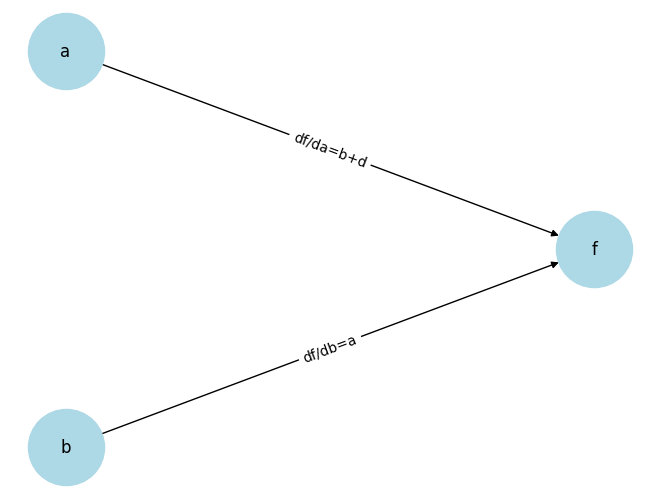

In [1051]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=b+d')
G.add_edge('b', 'f', label='df/db=a')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

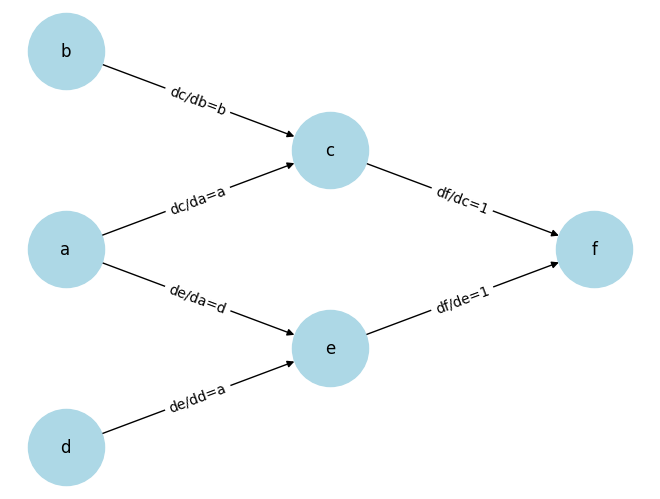

In [1052]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=a')
G.add_edge('b', 'c', label='dc/db=b')
G.add_edge('a', 'e', label='de/da=d')
G.add_edge('d', 'e', label='de/dd=a')
G.add_edge('c', 'f', label='df/dc=1')
G.add_edge('e', 'f', label='df/de=1')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [1053]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [1054]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above.


In [1055]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between

    Input:
    da:          The finite difference                           (float)

    Output:
    finite_difference: numerical approximation to the derivative (float)
    """

    fa_da = 0           # <- Insert correct expression
    fa = 0               # <- Insert correct expression

    finite_difference = (fa_da - fa) / da

    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
0.0


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [1056]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [1057]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T

    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)

    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)

    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma

    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [1058]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

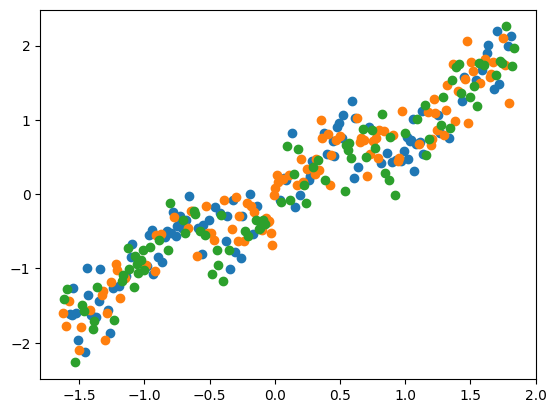

In [1059]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [1060]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y

x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it.
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [1061]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [1062]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [1063]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * weights[i][j]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out
    def print_parameters(self, layer_index: int):
        print(f"Layer {layer_index} parameters:")
        print("Weights:")
        for i, row in enumerate(self.weights):
            for j, weight in enumerate(row):
                print(f"  Weight[{i}][{j}]: {weight}")
        print("Biases:")
        for i, bias in enumerate(self.bias):
            print(f"  Bias[{i}]: {bias}")

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu).

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [1064]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output
print(forward(x_train, NN))


[[Var(v=-0.0083, grad=0.0000)], [Var(v=-0.0167, grad=0.0000)], [Var(v=-0.0015, grad=0.0000)], [Var(v=-0.0382, grad=0.0000)], [Var(v=-0.0123, grad=0.0000)], [Var(v=-0.0114, grad=0.0000)], [Var(v=-0.0074, grad=0.0000)], [Var(v=-0.0092, grad=0.0000)], [Var(v=-0.0394, grad=0.0000)], [Var(v=-0.0046, grad=0.0000)], [Var(v=-0.0128, grad=0.0000)], [Var(v=-0.0243, grad=0.0000)], [Var(v=-0.0103, grad=0.0000)], [Var(v=-0.0277, grad=0.0000)], [Var(v=-0.0055, grad=0.0000)], [Var(v=-0.0107, grad=0.0000)], [Var(v=-0.0197, grad=0.0000)], [Var(v=-0.0094, grad=0.0000)], [Var(v=-0.0010, grad=0.0000)], [Var(v=-0.0032, grad=0.0000)], [Var(v=-0.0182, grad=0.0000)], [Var(v=-0.0080, grad=0.0000)], [Var(v=-0.0144, grad=0.0000)], [Var(v=-0.0146, grad=0.0000)], [Var(v=-0.0106, grad=0.0000)], [Var(v=-0.0286, grad=0.0000)], [Var(v=-0.0187, grad=0.0000)], [Var(v=-0.0205, grad=0.0000)], [Var(v=-0.0022, grad=0.0000)], [Var(v=-0.0130, grad=0.0000)], [Var(v=-0.0359, grad=0.0000)], [Var(v=-0.0031, grad=0.0000)], [Var(v=

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var.

In [1065]:
# Insert code here and in the DenseLayer class
layer1 = DenseLayer(1, 5, lambda x: x.relu())
layer2 = DenseLayer(5, 1, lambda x: x.identity())

layer1.print_parameters(1)
layer2.print_parameters(2)


Layer 1 parameters:
Weights:
  Weight[0][0]: Var(v=0.0113, grad=0.0000)
  Weight[0][1]: Var(v=0.1231, grad=0.0000)
  Weight[0][2]: Var(v=0.0355, grad=0.0000)
  Weight[0][3]: Var(v=0.1041, grad=0.0000)
  Weight[0][4]: Var(v=0.0045, grad=0.0000)
Biases:
  Bias[0]: Var(v=0.0000, grad=0.0000)
  Bias[1]: Var(v=0.0000, grad=0.0000)
  Bias[2]: Var(v=0.0000, grad=0.0000)
  Bias[3]: Var(v=0.0000, grad=0.0000)
  Bias[4]: Var(v=0.0000, grad=0.0000)
Layer 2 parameters:
Weights:
  Weight[0][0]: Var(v=0.0109, grad=0.0000)
  Weight[1][0]: Var(v=0.0320, grad=0.0000)
  Weight[2][0]: Var(v=0.0211, grad=0.0000)
  Weight[3][0]: Var(v=0.0726, grad=0.0000)
  Weight[4][0]: Var(v=0.0366, grad=0.0000)
Biases:
  Bias[0]: Var(v=0.0000, grad=0.0000)


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

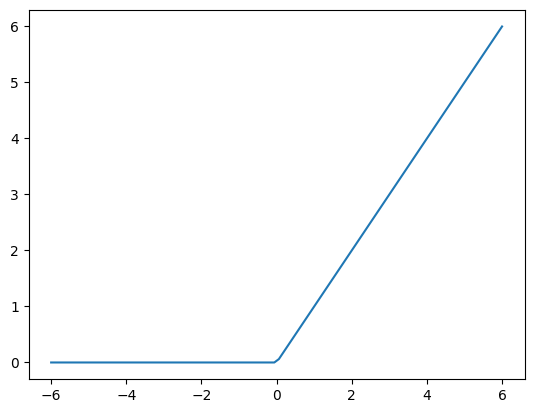

In [1066]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ]
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

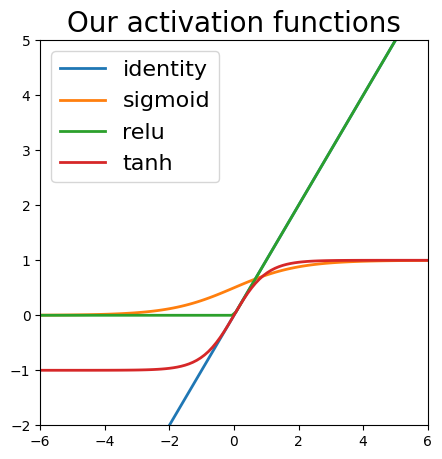

In [1067]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity()
    ,"sigmoid": lambda x: x.sigmoid()
    , "relu": lambda x: x.relu()
    , "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf).

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer.

The Glorot initialization has the form:

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).)

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization

Using the Initializer class, implement functions that implement Glorot and He

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [1068]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    std = np.sqrt(2/(n_in+n_out))
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = np.sqrt(2/n_in)
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions.

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands.

In [1069]:
# Insert code here
def test_forward_pass():
    input_data =np.array([1.0, 2.0])
    output_data=Var_to_nparray(forward(nparray_to_Var(input_data), [DenseLayer(1, 1, lambda x: x.identity(), initializer = ConstantInitializer(1.0))]) )

    expected_output = np.array([[1.0], [2.0]])
    assert np.allclose(output_data, expected_output), f"Expected {expected_output}, but got {output_data}"

    print("Forward pass unit test passed!")

# Run the unit test
test_forward_pass()

Forward pass unit test passed!


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [1070]:
def squared_loss(t, y):

  # add check that sizes agree

  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector.

Call the function to convince yourself it works.

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [1071]:
def cross_entropy_loss(t, h):

    Loss = Var(0.0)
    for i in range(len(t)):
        Loss += -t[i] * h[i].log() - (1-t[i]) * (1-h[i]).log()
        Loss = Loss * (1/len(t))
    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [1072]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [1073]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Layer 0 
 Weights: [[Var(v=0.0222, grad=-10.5919), Var(v=-0.1135, grad=-7.2469), Var(v=-0.0768, grad=-5.9323), Var(v=0.0886, grad=15.3854), Var(v=0.1082, grad=-13.2294)]] Biases: [Var(v=0.0000, grad=-9.0990), Var(v=0.0000, grad=6.5886), Var(v=0.0000, grad=5.3934), Var(v=0.0000, grad=13.2168), Var(v=0.0000, grad=-11.3648)]
Layer 1 
 Weights: [[Var(v=0.1046, grad=-2.2437)], [Var(v=0.0745, grad=11.0426)], [Var(v=0.0610, grad=7.4709)], [Var(v=-0.1519, grad=-8.9737)], [Var(v=0.1306, grad=-10.9585)]] Biases: [Var(v=0.0000, grad=1.4928)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [1074]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [1075]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Network before update:
Layer 0 
 Weights: [[Var(v=0.1146, grad=8.9614), Var(v=0.0470, grad=2.8855), Var(v=-0.2395, grad=-1.7367), Var(v=0.0912, grad=-7.8469), Var(v=-0.0513, grad=0.1600), Var(v=0.0202, grad=3.8105), Var(v=-0.0346, grad=-0.3039), Var(v=-0.1298, grad=-0.2078), Var(v=-0.1965, grad=0.8982), Var(v=-0.1544, grad=-4.8009), Var(v=-0.2152, grad=6.7615), Var(v=0.0585, grad=2.5475), Var(v=0.0124, grad=2.6661), Var(v=-0.0128, grad=3.1092), Var(v=0.0019, grad=-6.0338)]] Biases: [Var(v=0.0000, grad=7.6967), Var(v=0.0000, grad=2.4783), Var(v=0.0000, grad=1.5784), Var(v=0.0000, grad=-6.7395), Var(v=0.0000, grad=-0.1454), Var(v=0.0000, grad=3.2727), Var(v=0.0000, grad=0.2762), Var(v=0.0000, grad=0.1889), Var(v=0.0000, grad=-0.8163), Var(v=0.0000, grad=4.3633), Var(v=0.0000, grad=-6.1453), Var(v=0.0000, grad=2.1880), Var(v=0.0000, grad=2.2899), Var(v=0.0000, grad=-2.8259), Var(v=0.0000, grad=-5.1824)]
Layer 1 
 Weights: [[Var(v=-0.0841, grad=0.0000), Var(v=-0.0147, grad=-1.6374), Var(v=

[None, None, None]

In [1119]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 32, lambda x: x.relu()),
    DenseLayer(32, 1, lambda x: x.relu())
]

# Recommended hyper-parameters for 3-D:
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients
## of the activation functions.

In [1120]:
# Initialize training hyperparameters
EPOCHS = 400
LEARN_R = 0.0015

In [1110]:
train_loss = []
val_loss = []

for e in range(EPOCHS):

    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()

    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))

    # Training loss
    train_loss.append(Loss.v)

    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)

    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100),
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))



   0 ( 0.00%) Train loss: 104.665 	 Validation loss: 94.739
  10 ( 2.50%) Train loss: 16.897 	 Validation loss: 12.984
  20 ( 5.00%) Train loss: 13.888 	 Validation loss: 10.453
  30 ( 7.50%) Train loss: 13.559 	 Validation loss: 10.205
  40 (10.00%) Train loss: 13.270 	 Validation loss: 9.964
  50 (12.50%) Train loss: 12.984 	 Validation loss: 9.740
  60 (15.00%) Train loss: 12.740 	 Validation loss: 9.533
  70 (17.50%) Train loss: 12.514 	 Validation loss: 9.349
  80 (20.00%) Train loss: 12.351 	 Validation loss: 9.210
  90 (22.50%) Train loss: 12.196 	 Validation loss: 9.108
 100 (25.00%) Train loss: 12.091 	 Validation loss: 9.011
 110 (27.50%) Train loss: 12.027 	 Validation loss: 8.954
 120 (30.00%) Train loss: 11.983 	 Validation loss: 8.918
 130 (32.50%) Train loss: 11.954 	 Validation loss: 8.898
 140 (35.00%) Train loss: 11.934 	 Validation loss: 8.889
 150 (37.50%) Train loss: 11.918 	 Validation loss: 8.883
 160 (40.00%) Train loss: 11.905 	 Validation loss: 8.880
 170 (42.

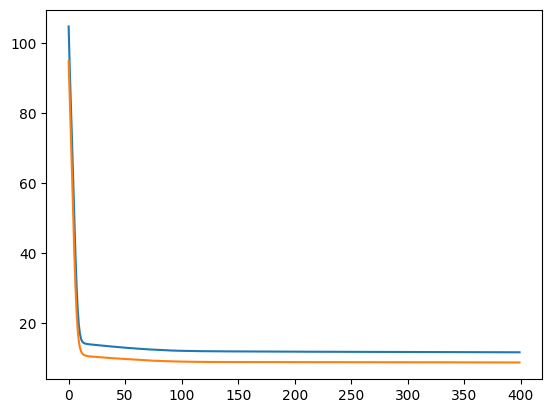

In [ ]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [1112]:
output_test = forward(x_test, NN)

Test loss:  9.631


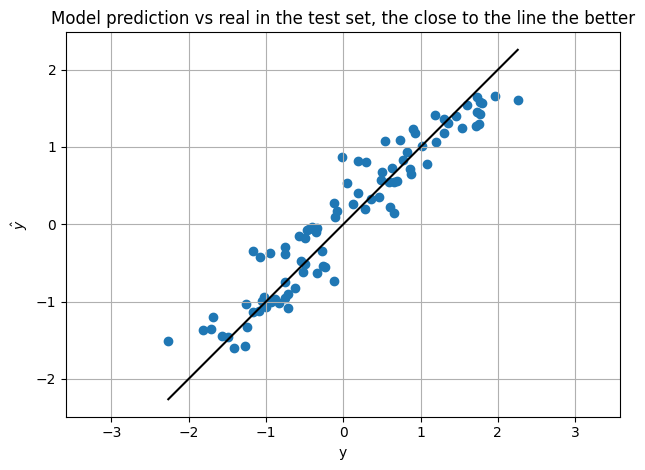

In [1113]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

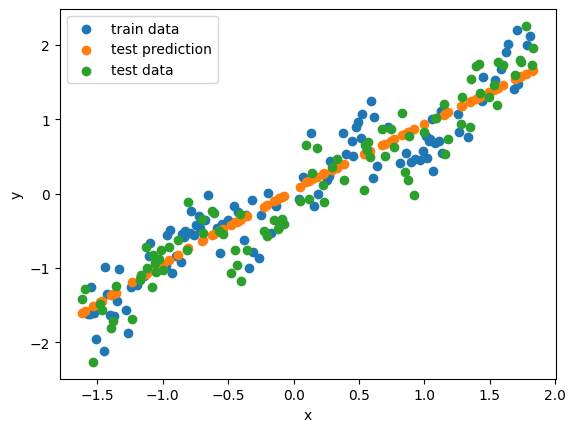

In [1114]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss.

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._

There are many ways to generate an underfitting model. Underfitting occurs when the model is too simple to capture the patterns of in the data. Therefore we created an underfitting model by making the learningrate bigger (0.004) hence forcing the model to prioritize learning too much. We shrink the learning time from 200 to only 100 making the model have too little time to utilize it's learnings. We used the original dataset size of 300. And finally we create a model that only consisted of 2 very simple layers: NN_underfit = [
    DenseLayer(1, 1, lambda x: x.relu()),
    DenseLayer(1, 1, lambda x: x.identity())
]. 

This gave us the following validation_loss and training_loss:

   0 ( 0.00%) Train loss: 104.930 	 Validation loss: 107.041
  10 (10.00%) Train loss: 25.219 	 Validation loss: 19.108
  20 (20.00%) Train loss: 17.919 	 Validation loss: 24.032
  30 (30.00%) Train loss: 27.566 	 Validation loss: 20.633
  40 (40.00%) Train loss: 18.276 	 Validation loss: 17.176
  50 (50.00%) Train loss: 22.662 	 Validation loss: 17.588
  60 (60.00%) Train loss: 100.174 	 Validation loss: 49.341
  70 (70.00%) Train loss: 76.745 	 Validation loss: 48.704
  80 (80.00%) Train loss: 75.392 	 Validation loss: 47.959
  90 (90.00%) Train loss: 73.820 	 Validation loss: 47.306

The high losses tells us that the model doesn't learn the underlying patterns in the data. The losses are also fluctuating which shows an instability in the learning process. 

We now try to overfit the model. Overfitting occurs when the model is too complex and has too many parameters allowing it to learn the whole training dataset. To create such a model we shrank the dataset to only consist of 20 datapoints making it easier for the model to learn.  We increased the learning time from 200 to 2000 making the model have much little time to the training data. And finally we create a model that only consisted of two complex layers: 

NN_underfit = [
    DenseLayer(1, 64, lambda x: x.relu()),
    DenseLayer(64, 1, lambda x: x.identity())
]. 

This gave us the following validation_loss and training_loss:
   0 ( 0.00%) Train loss: 3.041 	 Validation loss: 5.124
  10 ( 0.50%) Train loss: 2.773 	 Validation loss: 4.709
  20 ( 1.00%) Train loss: 2.545 	 Validation loss: 4.346
...
 230 (11.50%) Train loss: 0.073 	 Validation loss: 0.820
 240 (12.00%) Train loss: 0.057 	 Validation loss: 0.827
...
1980 (99.00%) Train loss: 0.000 	 Validation loss: 1.116
1990 (99.50%) Train loss: 0.000 	 Validation loss: 1.116

The result shows extremely low training loss indicating that the model is fitting the data extremely well, however it also shows that the long training time makes the model fit the training data too well and hence performs worse on the validation data in the end. We also see that the validation loss is relatively much bigger than the training loss in the end indicating a clear overfitting of the training data. 


At last we try and create a just right fit. Here we used the standarddataset of 300 datapoints that we were initially given. We tried different combinations of learningrates, learning time and neurual networks. The combinations that gave us the best fit was setting the training time to 400, setting the learning rate to 0.0015 and using the following NN: 


NN_JUSTRIGHT = [
    DenseLayer(1, 32, lambda x: x.relu()),
    DenseLayer(32, 1, lambda x: x.identity())
]. 

   0 ( 0.00%) Train loss: 104.665 	 Validation loss: 94.739
  10 ( 2.50%) Train loss: 16.897 	 Validation loss: 12.984
  20 ( 5.00%) Train loss: 13.888 	 Validation loss: 10.453

...
 380 (95.00%) Train loss: 11.691 	 Validation loss: 8.776
 390 (97.50%) Train loss: 11.682 	 Validation loss: 8.770

We observe that both the training and validation losses are relatively low and close to each other. This indicates that the model has achieved a good fit, effectively learning the underlying patterns in the data while still predict the unseen data well.

In [1115]:
# Insert your code for getting overfitting, underfitting and just right fitting
NN_underfit = [
    DenseLayer(1, 1, lambda x: x.relu()),
    DenseLayer(1, 1, lambda x: x.identity())
]
NN_justright = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

NN_overfit = [
    DenseLayer(1, 64, lambda x: x.relu()),
    DenseLayer(64, 1, lambda x: x.identity())
]


In [1116]:


#NN_overfitting loss
#    0 ( 0.00%) Train loss: 102.581 	 Validation loss: 81.817
#   10 ( 5.00%) Train loss: 13.376 	 Validation loss: 10.120
#   20 (10.00%) Train loss: 12.917 	 Validation loss: 9.718
#   30 (15.00%) Train loss: 12.627 	 Validation loss: 9.468
#   40 (20.00%) Train loss: 12.404 	 Validation loss: 9.277
#   50 (25.00%) Train loss: 12.250 	 Validation loss: 9.129
#   60 (30.00%) Train loss: 12.132 	 Validation loss: 9.032
#   70 (35.00%) Train loss: 12.041 	 Validation loss: 8.959
#   80 (40.00%) Train loss: 11.985 	 Validation loss: 8.916
#   90 (45.00%) Train loss: 11.946 	 Validation loss: 8.901
#  100 (50.00%) Train loss: 11.920 	 Validation loss: 8.899
#  110 (55.00%) Train loss: 11.905 	 Validation loss: 8.898
#  120 (60.00%) Train loss: 11.897 	 Validation loss: 8.905
#  130 (65.00%) Train loss: 11.893 	 Validation loss: 8.914
#  140 (70.00%) Train loss: 11.890 	 Validation loss: 8.922
#  150 (75.00%) Train loss: 11.888 	 Validation loss: 8.928
#  160 (80.00%) Train loss: 11.886 	 Validation loss: 8.933
#  170 (85.00%) Train loss: 11.885 	 Validation loss: 8.936
#  180 (90.00%) Train loss: 11.882 	 Validation loss: 8.939
#  190 (95.00%) Train loss: 11.880 	 Validation loss: 8.942

#NN_underfitting loss
#    0 ( 0.00%) Train loss: 104.843 	 Validation loss: 107.451
#   10 ( 5.00%) Train loss: 90.689 	 Validation loss: 83.956
#   20 (10.00%) Train loss: 26.025 	 Validation loss: 20.816
#   30 (15.00%) Train loss: 19.844 	 Validation loss: 15.413
#   40 (20.00%) Train loss: 15.491 	 Validation loss: 12.167
#   50 (25.00%) Train loss: 13.229 	 Validation loss: 10.362
#   60 (30.00%) Train loss: 12.522 	 Validation loss: 9.757
#   70 (35.00%) Train loss: 12.251 	 Validation loss: 9.456
#   80 (40.00%) Train loss: 12.139 	 Validation loss: 9.248
#   90 (45.00%) Train loss: 12.075 	 Validation loss: 9.131
#  100 (50.00%) Train loss: 12.056 	 Validation loss: 9.095
#  110 (55.00%) Train loss: 12.049 	 Validation loss: 9.061
#  120 (60.00%) Train loss: 12.047 	 Validation loss: 9.055
#  130 (65.00%) Train loss: 12.045 	 Validation loss: 9.050
#  140 (70.00%) Train loss: 12.044 	 Validation loss: 9.045
#  150 (75.00%) Train loss: 12.042 	 Validation loss: 9.061
#  160 (80.00%) Train loss: 12.036 	 Validation loss: 9.042
#  170 (85.00%) Train loss: 12.034 	 Validation loss: 9.034
#  180 (90.00%) Train loss: 12.033 	 Validation loss: 9.030
#  190 (95.00%) Train loss: 12.032 	 Validation loss: 9.024


#NN_rightfitting loss
#    0 ( 0.00%) Train loss: 110.132 	 Validation loss: 106.416
#   10 ( 5.00%) Train loss: 37.020 	 Validation loss: 28.108
#   20 (10.00%) Train loss: 19.000 	 Validation loss: 14.766
#   30 (15.00%) Train loss: 14.901 	 Validation loss: 11.193
#   40 (20.00%) Train loss: 13.302 	 Validation loss: 9.955
#   50 (25.00%) Train loss: 12.394 	 Validation loss: 9.376
#   60 (30.00%) Train loss: 12.154 	 Validation loss: 9.136
#   70 (35.00%) Train loss: 12.068 	 Validation loss: 9.055
#   80 (40.00%) Train loss: 12.013 	 Validation loss: 9.039
#   90 (45.00%) Train loss: 11.975 	 Validation loss: 9.019
#  100 (50.00%) Train loss: 11.950 	 Validation loss: 9.001
#  110 (55.00%) Train loss: 11.936 	 Validation loss: 8.994
#  120 (60.00%) Train loss: 11.927 	 Validation loss: 8.990
#  130 (65.00%) Train loss: 11.922 	 Validation loss: 8.985
#  140 (70.00%) Train loss: 11.918 	 Validation loss: 8.980
#  150 (75.00%) Train loss: 11.914 	 Validation loss: 8.978
#  160 (80.00%) Train loss: 11.912 	 Validation loss: 8.975
#  170 (85.00%) Train loss: 11.910 	 Validation loss: 8.975
#  180 (90.00%) Train loss: 11.908 	 Validation loss: 8.970
#  190 (95.00%) Train loss: 11.906 	 Validation loss: 8.977


#underfit: learningrate alt for stor, leraningtime lille, da vil vi underfitte
# overfit: varier størrelsen på datasæt, lav det mindre

# Next steps - classification

It is straight forward to extend what we have done to classification.

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week.

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [1117]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it.

In [1118]:
# just add some code